# Replicating Experiments from paper

In [157]:
%pip install git+https://github.com/ericsuh/dirichlet.git

  Cloning https://github.com/ericsuh/dirichlet.git to /private/var/folders/h6/l21knyzn0j1919wpph_4f6qr0000gn/T/pip-req-build-fktae9uy
  Running command git clone --filter=blob:none --quiet https://github.com/ericsuh/dirichlet.git /private/var/folders/h6/l21knyzn0j1919wpph_4f6qr0000gn/T/pip-req-build-fktae9uy
  Resolved https://github.com/ericsuh/dirichlet.git to commit acc368e045b652076d8cc5297f65e1b9ba527756
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [158]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List, Optional, Tuple
from tqdm import tqdm
from scipy.special import psi, polygamma, gammaln

In [159]:
def plot_changes(data, true_changes, detected_changes, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data, label=None)
    for cp in true_changes:
        plt.axvline(cp, color='green', linestyle='--', label='True Change Point')
    for cp in detected_changes:
        plt.axvline(cp, color='red', linestyle='--', label='Estimated Change Point (MLE)')
    plt.title(title)
    plt.legend()
    plt.show()

In [160]:
def dirichlet_mle(X):
    """Maximum Likelihood Estimation for Dirichlet distribution parameters using the fixed point iteration from the package
    """
    import dirichlet

    return dirichlet.mle(X, method='fixed_point')

def log_likelihood(X, alpha):
    """
    Log-likelihood of data X under Dirichlet(alpha).
    """
    n, d = X.shape
    alpha0 = np.sum(alpha)
    ll = n * (gammaln(alpha0) - np.sum(gammaln(alpha)))
    ll += np.sum((alpha - 1) * np.log(X))
    return ll

In [161]:
# sequence with 3 changes
change_mean_var = np.random.normal(0, 1, 100)

# change variance of points from 20 to 50 by multiplying by 3
change_mean_var[20:] *= np.sqrt(3)

# change mean of points from 50 onwards by adding 2
change_mean_var[50:] += 2

# change variance of points from 80 onwards by multiplying by 2
change_mean_var[80:] *= 2

true_changes_mean_var = [20, 50, 80]

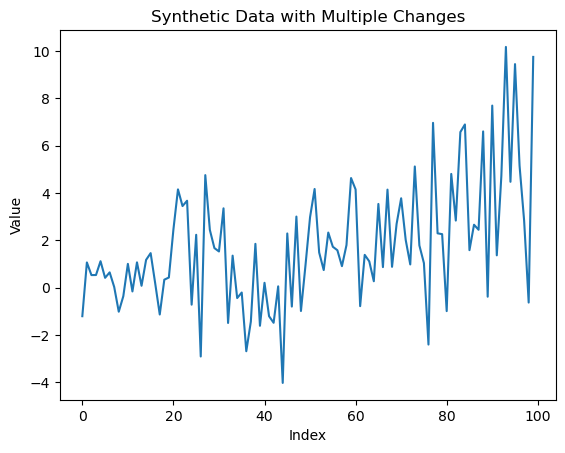

In [162]:
plt.plot(change_mean_var)
plt.title("Synthetic Data with Multiple Changes")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()

In [163]:
change_covariance = np.random.multivariate_normal(
    np.zeros(3),
    np.eye(3),
    size=20
)

change_covariance = np.concatenate((change_covariance, np.random.multivariate_normal(
    np.zeros(3),
    np.array([
        [1, 0.9, 0.9],
        [0.9, 1, 0.9],
        [0.9, 0.9, 1]
    ]),
    size=40
)))

change_covariance = np.concatenate((change_covariance, np.random.multivariate_normal(
    np.zeros(3),
    np.eye(3),
    size=40
)))

true_changes_covariance = [20, 60]

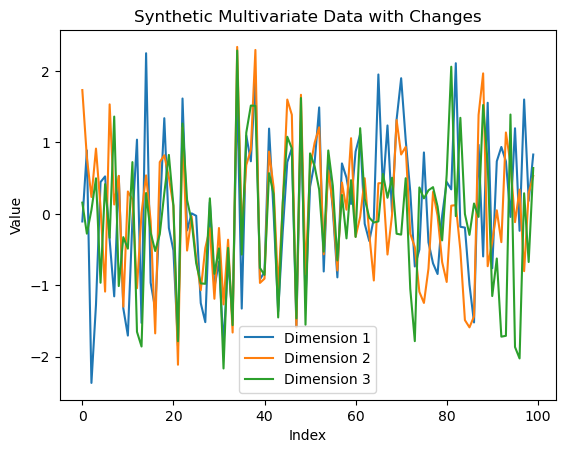

In [164]:
plt.plot(change_covariance[:, 0], label='Dimension 1')
plt.plot(change_covariance[:, 1], label='Dimension 2')
plt.plot(change_covariance[:, 2], label='Dimension 3')
plt.legend()
plt.title("Synthetic Multivariate Data with Changes")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()

In [165]:
# sequence with change in tail behavior
change_tail = np.random.multivariate_normal(
    np.zeros(2),
    np.eye(2),
    size=60
)

# next 40 samples are drawn from a bivariate t distribution with 2 degrees of freedom
change_tail = np.concatenate([change_tail, np.random.standard_t(2, size=(40, 2))])

true_changes_tail = [60]

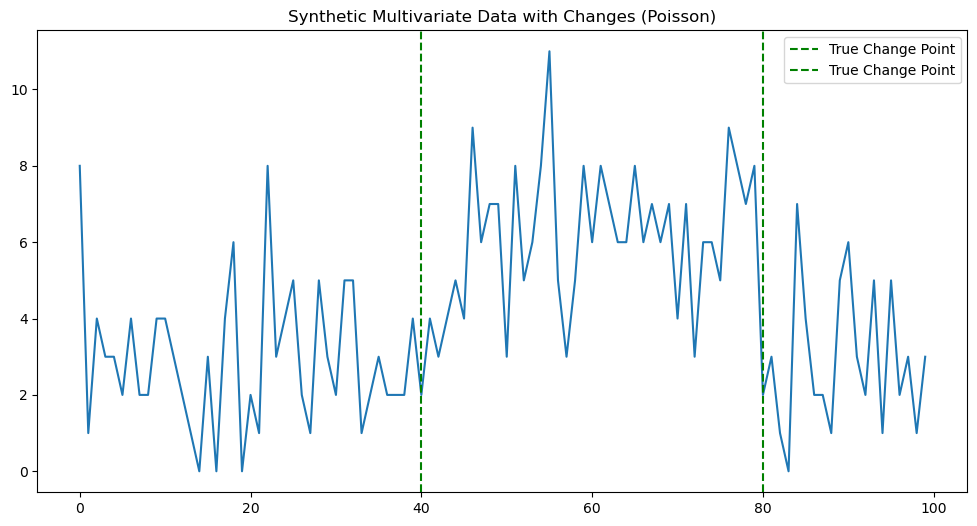

In [166]:
# sequence with change in Poisson intensity parameter
change_poisson = np.random.poisson(lam=3, size=40)

# next 40 samples are drawn from a Poisson distribution with a higher intensity
change_poisson = np.concatenate([change_poisson, np.random.poisson(lam=6, size=40)])

# change back to the original intensity
change_poisson = np.concatenate([change_poisson, np.random.poisson(lam=3, size=20)])

true_changes_poisson = [40, 80]

plot_changes(change_poisson, true_changes_poisson, [], "Synthetic Multivariate Data with Changes (Poisson)")

In [167]:
# sparse change in mean with overlapping segments
change_sparse = np.random.multivariate_normal(
    np.zeros(50),
    np.eye(50),
    size=100
)

# change mean of points from 20 to 22 by adding 5
mean_change = np.zeros(50)
mean_change[20:22] = 5
change_sparse[50:] += mean_change

# change mean of points from 40 to 42 by adding 10
mean_change = np.zeros(50)
mean_change[40:42] = 10
change_sparse[80:] += mean_change

true_changes_sparse = [50, 80]

In [168]:
# sequence with change in Poisson intensity parameter
change_poisson = np.random.poisson(lam=3, size=40)

# next 40 samples are drawn from a Poisson distribution with a higher intensity
change_poisson = np.concatenate([change_poisson, np.random.poisson(lam=6, size=40)])

# change back to the original intensity
change_poisson = np.concatenate([change_poisson, np.random.poisson(lam=3, size=20)])

true_changes_poisson = [40, 80]

In [169]:
def random_subset_test(active_window, tau_star, Z_star, M=1000, alpha=0.001):
    """
    Random Subset Test for significance of a change point.

    Parameters:
    - active_window: np.ndarray of shape (t, d), compositional data
    - tau_star: int, candidate change point index (1 <= tau_star < t)
    - Z_star: float, observed log-likelihood ratio for tau_star
    - M: int, number of random subsets
    - alpha: float, significance level

    Returns:
    - bool: True if significant change point, False otherwise
    """
    t = active_window.shape[0]
    exceed_count = 0

    for _ in range(M):
        # Randomly choose tau_star points for "left" subset
        left_idx = np.random.choice(t, size=tau_star, replace=False)
        right_idx = np.setdiff1d(np.arange(t), left_idx)

        left_data = active_window[left_idx]
        right_data = active_window[right_idx]

        # MLE fits for both halves
        alpha_L = dirichlet_mle(left_data)
        alpha_R = dirichlet_mle(right_data)
        alpha_all = dirichlet_mle(active_window)

        # Compute log-likelihoods
        LL_L = log_likelihood(left_data, alpha_L)
        LL_R = log_likelihood(right_data, alpha_R)
        LL_tau = LL_L + LL_R
        LL0 = log_likelihood(active_window, alpha_all)

        Z_m = LL_tau - LL0

        if Z_m >= Z_star:
            exceed_count += 1

    # Approximate p-value
    p_value = exceed_count / M
    return p_value <= alpha


In [170]:
def find_single_cp(active_window, M=1000, alpha=0.001, min_seg_size=50):
    """
    Detect a single change point in the given active window using the ODCP approach.

    Parameters:
    - active_window: np.ndarray of shape (t, d), compositional data (rows sum to 1)
    - M: number of random subsets for significance testing
    - alpha: significance level
    - min_seg_size: minimum segment size on either side of a candidate change point

    Returns:
    - cp_index: int or None, index of detected change point within active_window
    - Z_star: float, test statistic for the detected change point
    """
    t, d = active_window.shape

    # Fit MLE for the whole window (H0)
    alpha_all = dirichlet_mle(active_window)
    LL0 = log_likelihood(active_window, alpha_all)

    best_tau = None
    best_LL = -np.inf

    # Test each possible split point τ
    for tau in range(min_seg_size, t - min_seg_size + 1):
        left = active_window[:tau]
        right = active_window[tau:]

        alpha_L = dirichlet_mle(left)
        alpha_R = dirichlet_mle(right)

        LL_tau = log_likelihood(left, alpha_L) + log_likelihood(right, alpha_R)

        if LL_tau > best_LL:
            best_LL = LL_tau
            best_tau = tau

    if best_tau is None:
        return None, None

    # Compute observed test statistic
    Z_star = best_LL - LL0

    print(f"=> Best candidate change point found at index {best_tau} with Z_star = {Z_star:.4f}")

    # Run significance test
    significant = random_subset_test(active_window, best_tau, Z_star, M=M, alpha=alpha)

    if significant:
        print(f"  => Candidate is a significant change point.")
        return best_tau, Z_star
    else:
        print(f"  => Estimated change was not significant.")
        return None, Z_star

In [171]:
def detect_multiple_cps(
    data: np.ndarray,
    find_single_cp: Callable[[np.ndarray, int, float, int], Tuple[Optional[int], Optional[float]]],
    I: int = 50,        # initial active window size
    K: int = 20,        # minimum number of samples to attempt MLE / detection
    b: int = 20,        # batch size to append when no CP found
    M: int = 1000,      # number of random subsets used in significance testing
    alpha: float = 0.001, # significance level for the random-subset test
    verbose: bool = True
) -> Tuple[List[int], List[float]]:
    """
    Online multiple change-point detection controller (Algorithm 1 / ODCP).

    Parameters
    ----------
    data : np.ndarray, shape (T, d)
        Full time-series / multivariate data (compositional). Rows are time points.
    find_single_cp : callable
        Function that accepts (active_window, M, alpha, min_seg_size) and returns
        (cp_index_relative, Z_star). cp_index_relative is relative to active_window start.
    I : int
        Initial active window size (default 50 from the paper).
    K : int
        Minimum number of samples to attempt MLE/detection (default 50).
    b : int
        Batch size to append when no CP is found (default 20).
    M : int
        Number of random subsets for the significance test (passed to find_single_cp).
    alpha : float
        Significance level for the test (passed to find_single_cp).
    min_seg_size : int
        Minimum segment size on either side of candidate split.
    verbose : bool
        If True, print progress messages.

    Returns
    -------
    cps_global : List[int]
        Sorted list of detected change-point indices in the original data array.
        (0-based indices; each entry is the index of the boundary point tau such that
         left segment is data[:tau] and right starts at data[tau:]).
    stats : List[float]
        The corresponding Z* test statistic for each detected CP (same order as cps_global).
    """
    T = data.shape[0]
    cps_global: List[int] = []
    stats: List[float] = []

    # start is the index in the original data of the first point in the active window
    start = 0
    # end is exclusive index (Python style). Initialize to start + I or T
    end = min(start + I, T)

    # safety guard: maximum iterations to avoid pathological infinite loops
    max_iters = max(10000, T * 10)
    iter_count = 0

    while start + K <= T and iter_count < max_iters:
        iter_count += 1
        # current active window (rows start .. end-1)
        A = data[start:end]

        if verbose:
            print(f"[iter {iter_count}] Active window start={start}, end={end}, size={A.shape[0]}")

        # Only try detection if we have at least K points (as in the paper)
        if A.shape[0] >= K:
            # call the single-CP finder; pass M and alpha through
            cp_rel, Z_star = find_single_cp(A, M=M, alpha=alpha, min_seg_size=K)

            if cp_rel is not None:
                # convert relative index to global index in original data
                # cp_rel is the index where the split happens inside A (1..len(A)-1)
                cp_global = start + cp_rel

                # append result
                cps_global.append(int(cp_global))
                stats.append(float(Z_star) if Z_star is not None else float('nan'))

                if verbose:
                    print(f"  => Found CP at relative {cp_rel}, global {cp_global}, Z*={Z_star}")

                # Prune data before the discovered change point and reset the active window
                # According to paper, reset A = {x_tau, ..., x_{tau+I}} i.e., start = cp_global
                start = cp_global
                end = min(start + I, T)
                # Continue main loop from the new window
                continue
            else:
                if verbose:
                    print("  => No significant CP found in this active window.")
        else:
            if verbose:
                print(f"  => Active window too small ({A.shape[0]} < K={K}). Will append batch if possible.")

        # If no CP found (or active window too small), append a batch (b) of next points if available
        if end >= T:
            # no more new points to append and nothing found -> stop
            if verbose:
                print("  => End of data reached, stopping.")
            break
        # extend end by batch size
        new_end = min(end + b, T)
        # Guard: if new_end == end then no progress possible
        if new_end == end:
            if verbose:
                print("  => Cannot extend window further, stopping.")
            break
        end = new_end
        if verbose:
            print(f"  => Appended batch, new active window end={end}")

    if iter_count >= max_iters and verbose:
        print("Warning: reached maximum iterations limit in detect_multiple_cps")

    return cps_global, stats


[iter 1] Active window start=0, end=50, size=50
=> Best candidate change point found at index 20 with Z_star = 1.9918
  => Estimated change was not significant.
  => No significant CP found in this active window.
  => Appended batch, new active window end=70
[iter 2] Active window start=0, end=70, size=70
=> Best candidate change point found at index 50 with Z_star = 13.6167
  => Candidate is a significant change point.
  => Found CP at relative 50, global 50, Z*=13.616654914206833
[iter 3] Active window start=50, end=100, size=50
=> Best candidate change point found at index 20 with Z_star = 12.4767
  => Estimated change was not significant.
  => No significant CP found in this active window.
  => End of data reached, stopping.
Detected CP at: [50], Test statistic: [13.616654914206833]


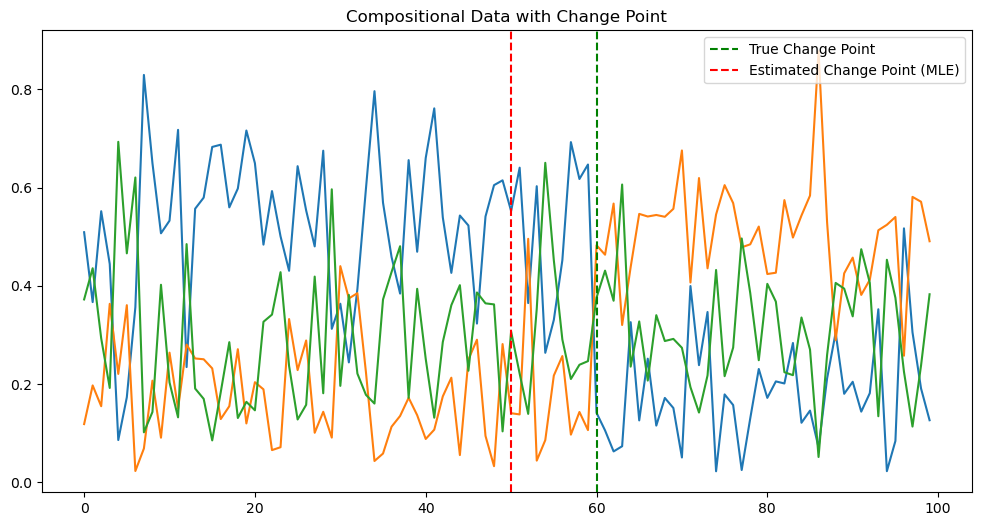

In [172]:
from numpy.random import dirichlet

# Generate sample compositional data with a change point at t=60
np.random.seed(0)
X1 = dirichlet([5, 2, 3], size=60)
X2 = dirichlet([2, 6, 4], size=40)
window = np.vstack([X1, X2])

cp, stat = detect_multiple_cps(window, find_single_cp=find_single_cp)
print(f"Detected CP at: {cp}, Test statistic: {stat}")
plot_changes(window, [60], cp, "Compositional Data with Change Point")

In [173]:
def map_to_simplex(data: np.ndarray) -> np.ndarray:
    """
    Map data to the simplex space (compositional data).

    Parameters:
    - data: np.ndarray of shape (n_samples, n_features), raw data

    Returns:
    - np.ndarray of shape (n_samples, n_features+1), mapped to simplex
    """
    if data.ndim == 1:
        data = data.reshape(-1, 1)

    # add an extra entry to get the simplex dimension
    data = np.concatenate((data, np.zeros((data.shape[0], 1))), axis=1)

    # add a small constant to each element
    data = data + 1e-8

    # take exponential to ensure positivity
    data = np.exp(data)

    # normalize to sum to 1
    data = data / np.sum(data, axis=1, keepdims=True)

    assert np.allclose(np.sum(data, axis=1), 1), "Data must sum to 1 after mapping to simplex."

    return data

[iter 1] Active window start=0, end=50, size=50
=> Best candidate change point found at index 20 with Z_star = 9.1771
  => Candidate is a significant change point.
  => Found CP at relative 20, global 20, Z*=9.177069822117193
[iter 2] Active window start=20, end=70, size=50
=> Best candidate change point found at index 29 with Z_star = 6.6976
  => Candidate is a significant change point.
  => Found CP at relative 29, global 49, Z*=6.697624385764357
[iter 3] Active window start=49, end=99, size=50
=> Best candidate change point found at index 27 with Z_star = 6.6102
  => Estimated change was not significant.
  => No significant CP found in this active window.
  => Appended batch, new active window end=100
[iter 4] Active window start=49, end=100, size=51
=> Best candidate change point found at index 27 with Z_star = 7.3037
  => Estimated change was not significant.
  => No significant CP found in this active window.
  => End of data reached, stopping.
Detected change points (mean_var): 

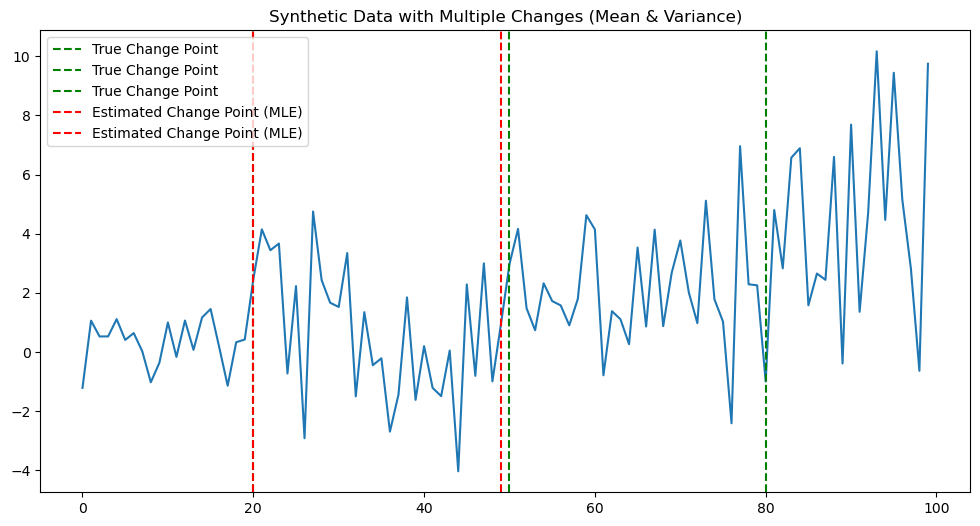

In [174]:
changes_detected_mean_var, stats_detected_mean_var = detect_multiple_cps(map_to_simplex(change_mean_var), find_single_cp=find_single_cp)
print("Detected change points (mean_var):", changes_detected_mean_var)
print("Statistics for detected change points (mean_var):", stats_detected_mean_var)
plot_changes(change_mean_var, true_changes_mean_var, changes_detected_mean_var, "Synthetic Data with Multiple Changes (Mean & Variance)")

[iter 1] Active window start=0, end=50, size=50
=> Best candidate change point found at index 22 with Z_star = 2.9592
  => Estimated change was not significant.
  => No significant CP found in this active window.
  => Appended batch, new active window end=70
[iter 2] Active window start=0, end=70, size=70
=> Best candidate change point found at index 50 with Z_star = 9.2316
  => Candidate is a significant change point.
  => Found CP at relative 50, global 50, Z*=9.231646983199653
[iter 3] Active window start=50, end=100, size=50
=> Best candidate change point found at index 23 with Z_star = 8.9208
  => Candidate is a significant change point.
  => Found CP at relative 23, global 73, Z*=8.92076854688949
[iter 4] Active window start=73, end=100, size=27
  => No significant CP found in this active window.
  => End of data reached, stopping.
Detected change points (covariance): [50, 73]
Statistics for detected change points (covariance): [9.231646983199653, 8.92076854688949]


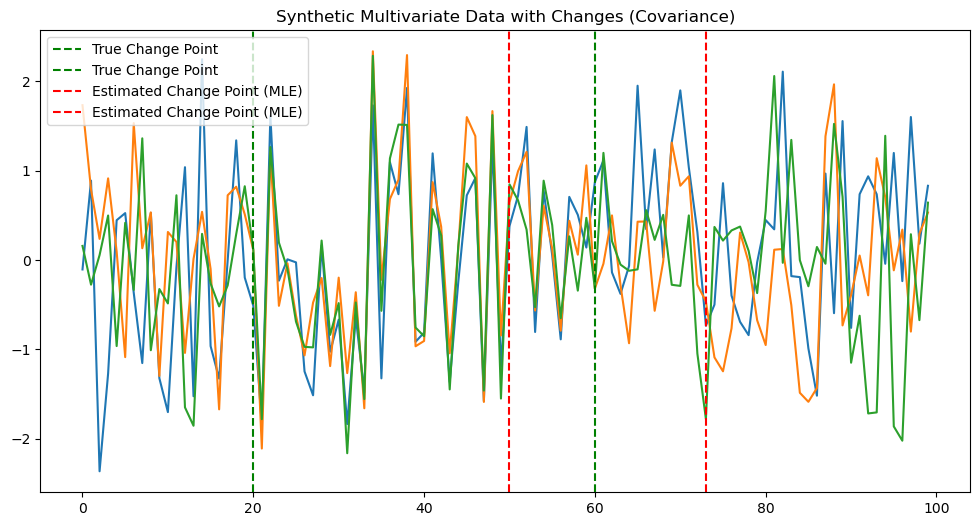

In [175]:
change_covariance_simplex = map_to_simplex(change_covariance)
changes_detected_covariance, stats_detected_covariance = detect_multiple_cps(change_covariance_simplex, find_single_cp=find_single_cp)
print("Detected change points (covariance):", changes_detected_covariance)
print("Statistics for detected change points (covariance):", stats_detected_covariance)
plot_changes(change_covariance, true_changes_covariance, changes_detected_covariance, "Synthetic Multivariate Data with Changes (Covariance)")

[iter 1] Active window start=0, end=50, size=50
=> Best candidate change point found at index 27 with Z_star = 3.5082
  => Estimated change was not significant.
  => No significant CP found in this active window.
  => Appended batch, new active window end=70
[iter 2] Active window start=0, end=70, size=70
=> Best candidate change point found at index 27 with Z_star = 3.1766
  => Estimated change was not significant.
  => No significant CP found in this active window.
  => Appended batch, new active window end=90
[iter 3] Active window start=0, end=90, size=90
=> Best candidate change point found at index 64 with Z_star = 13.6023
  => Estimated change was not significant.
  => No significant CP found in this active window.
  => Appended batch, new active window end=100
[iter 4] Active window start=0, end=100, size=100
=> Best candidate change point found at index 80 with Z_star = 35.1454
  => Candidate is a significant change point.
  => Found CP at relative 80, global 80, Z*=35.1454271

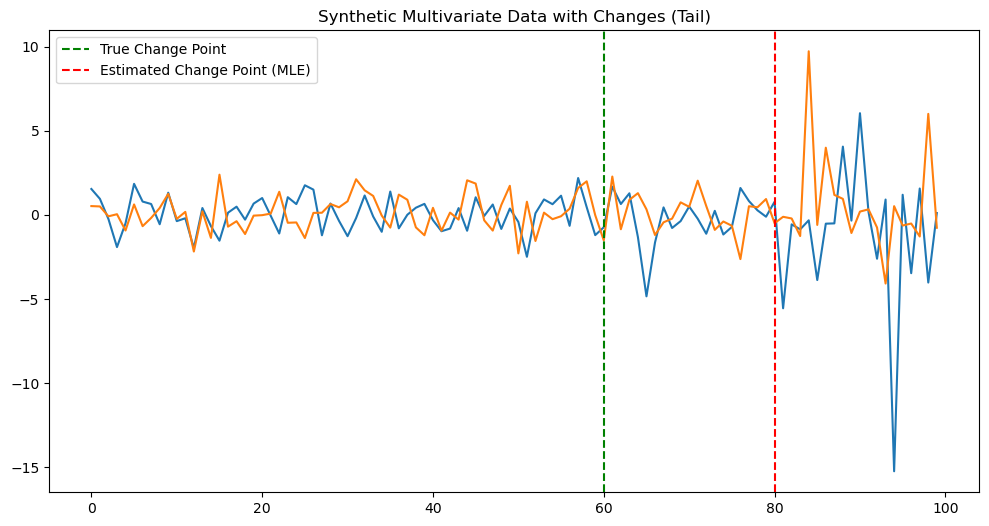

In [176]:
change_tail_simplex = map_to_simplex(change_tail)
changes_detected_tail, stats_detected_tail = detect_multiple_cps(change_tail_simplex, find_single_cp=find_single_cp)
print("Detected change points (tail):", changes_detected_tail)
print("Statistics for detected change points (tail):", stats_detected_tail)
plot_changes(change_tail, true_changes_tail, changes_detected_tail, "Synthetic Multivariate Data with Changes (Tail)")

[iter 1] Active window start=0, end=50, size=50
=> Best candidate change point found at index 30 with Z_star = 22.9241
  => Estimated change was not significant.
  => No significant CP found in this active window.
  => Appended batch, new active window end=70
[iter 2] Active window start=0, end=70, size=70
=> Best candidate change point found at index 50 with Z_star = 822.4416
  => Candidate is a significant change point.
  => Found CP at relative 50, global 50, Z*=822.4415917057959
[iter 3] Active window start=50, end=100, size=50
=> Best candidate change point found at index 30 with Z_star = 1009.7528
  => Candidate is a significant change point.
  => Found CP at relative 30, global 80, Z*=1009.7528345195406
[iter 4] Active window start=80, end=100, size=20
  => No significant CP found in this active window.
  => End of data reached, stopping.
Detected change points (sparse): [50, 80]
Statistics for detected change points (sparse): [822.4415917057959, 1009.7528345195406]


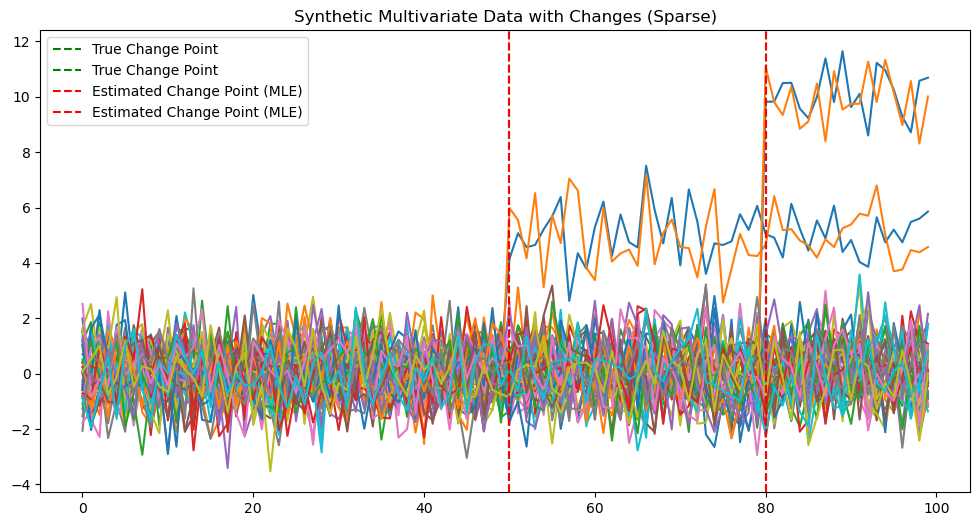

In [177]:
change_sparse_simplex = map_to_simplex(change_sparse)
changes_detected_sparse, stats_detected_sparse = detect_multiple_cps(change_sparse_simplex, find_single_cp=find_single_cp)
print("Detected change points (sparse):", changes_detected_sparse)
print("Statistics for detected change points (sparse):", stats_detected_sparse)
plot_changes(change_sparse, true_changes_sparse, changes_detected_sparse, "Synthetic Multivariate Data with Changes (Sparse)")

[iter 1] Active window start=0, end=50, size=50
=> Best candidate change point found at index 29 with Z_star = 3.4205
  => Estimated change was not significant.
  => No significant CP found in this active window.
  => Appended batch, new active window end=70
[iter 2] Active window start=0, end=70, size=70
=> Best candidate change point found at index 40 with Z_star = 21.3550
  => Candidate is a significant change point.
  => Found CP at relative 40, global 40, Z*=21.355014645424262
[iter 3] Active window start=40, end=90, size=50
=> Best candidate change point found at index 26 with Z_star = 7.4874
  => Candidate is a significant change point.
  => Found CP at relative 26, global 66, Z*=7.487353101118998
[iter 4] Active window start=66, end=100, size=34
  => No significant CP found in this active window.
  => End of data reached, stopping.
Detected change points (poisson): [40, 66]
Statistics for detected change points (poisson): [21.355014645424262, 7.487353101118998]


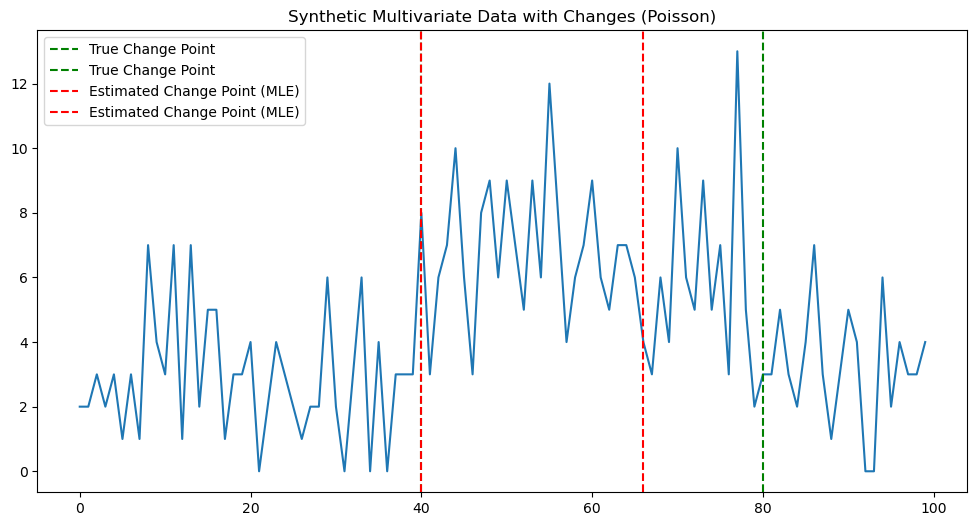

In [178]:
change_poisson_simplex = map_to_simplex(change_poisson)
changes_detected_poisson, stats_detected_poisson = detect_multiple_cps(change_poisson_simplex, find_single_cp=find_single_cp)
print("Detected change points (poisson):", changes_detected_poisson)
print("Statistics for detected change points (poisson):", stats_detected_poisson)
plot_changes(change_poisson, true_changes_poisson, changes_detected_poisson, "Synthetic Multivariate Data with Changes (Poisson)")